# Previsión de Ocurrencias de Crisis Epilépticas

El objetivo de este Notebook es crear un modelo de previsión de crisis epilépticas. Se utilizarán datos publicos dispoibles en el sitio de UCI. Se usan cuatro clasificadores disponibles en el paquete de scikit learn. 

In [192]:
#!pip3 install xgboost
#!pip3 install scikit-plot

In [139]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import sklearn as sk
import xgboost as xgb
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [193]:
# Versiones de los paquetes usados en este notebook

%reload_ext watermark
%watermark -a "César S. Hooper/ Dic 2021" --iversions
!python --version

Author: César S. Hooper/ Dic 2021

scipy     : 1.4.1
matplotlib: 3.3.4
scikitplot: 0.3.7
sklearn   : 0.24.1
xgboost   : 1.5.1
seaborn   : 0.11.1
h5py      : 2.10.0
pandas    : 1.2.4
numpy     : 1.19.5

Python 3.8.8


### Sobre los datos
Los datos están disponibles en un repositorio de datos para Machine Learning de la UCI. Aquí abajo dejo el link.

https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

El conjunto de datos incluye 4097 lecturas de electroencefalograma (EEG) por paciente, durante 23.5 segundos, con 500 pacientes en total. Los 4097 puntos de datos fueron divididos en 23 partes por paciente, cada parte se convirtió en una fila con 178 valores en el conjunto de datos. En otras palabras, cada paciente aportó con 23 filas con 178 datos cada una al conjunto de datos. Como en total tenemos 500 pacientes, el conjunto de datos tiene 11.500 filas de 179 columnas. La columna 179 contiene el Status del paciente, esté teniendo una convulsión o no.

La última columna etiqueta el status de cada paciente {1, 2, 3, 4, 5}, los pacientes con status 2, 3, 4 ó 5 no están teniendo un ataque epiléptico. Sólo los pacientes etiquetados con status 1 están teniendo un ataque epiléptico.

### Explorando los datos

In [4]:
path = 'C:/Users/Cesar Hooper/Desktop/python/mini_projeto1/dados/dados_originais.csv'
dataset = pd.read_csv(path)

In [5]:
dataset.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
# Eliminamos la primera columna
dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [7]:
dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


En la última columna está el status del paciente. Sólo cuando el estatus es 1 el paciente está teniendo una convulsión. Así que pondremos 1 para los pacientes con crisis epiléptica, y 0 para los demás.


In [8]:
dataset['y'] = np.where(dataset.y == 1, 1, 0)

In [210]:
dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


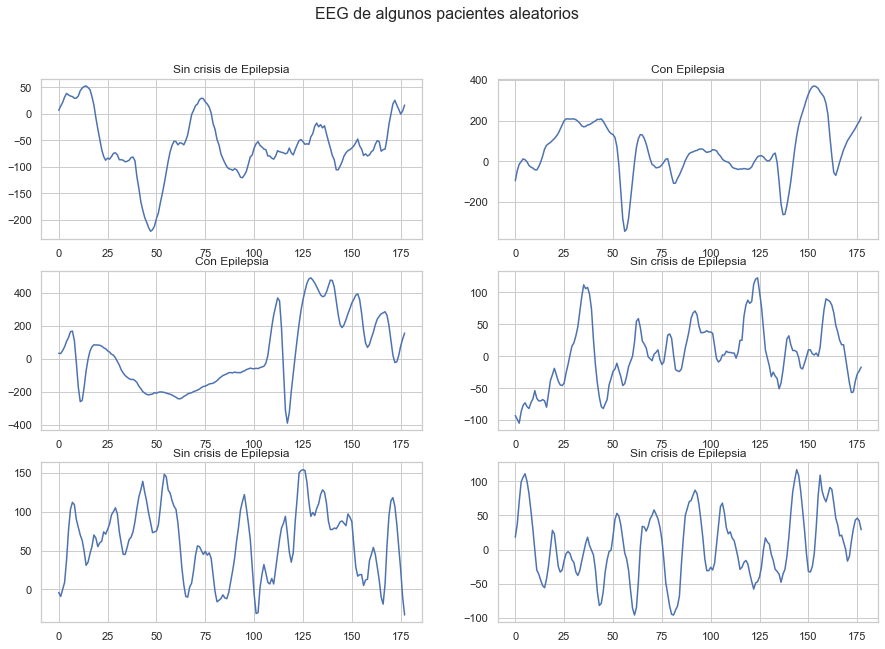

In [253]:
lista = list(np.random.randint(100, len(dataset), 6))
m = 1 
plt.figure(figsize=(15,10))
for k in lista:
    x = list(dataset.iloc[k][0:-1])       
    plt.subplot(3, 2, m)
    if dataset.iloc[k][-1]==0: plt.title('Sin crisis de Epilepsia')
    else: plt.title('Con Epilepsia')
    plt.suptitle('EEG de algunos pacientes aleatorios', fontsize=16)
    plt.plot(x)
    m += 1
    

### Prevalencia
La prevalencia es el porcentaje de casos con las característica que se está intentando predecir. En nuestro caso, nos interea qué porcentaje de pacientes con crisis epiléptica tenemos en nuestro conjunto de datos. 

In [10]:
# prevalencia de pacientes con crisis 
prev_datos = 100*sum(dataset.y)/len(dataset.y)
print('El porcentaje de casos con crisis es %.1f'%prev_datos + '%')

El porcentaje de casos con crisis es 20.0%


Al momento de separar los datos en test y entrenamiento debemos mantener la prevalencia

In [11]:
y = dataset['y']
X = dataset.drop(['y'], axis=1)

In [12]:
# Separamos los datos en
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
dato = sum(dataset.y)/len(dataset.y)
train = sum(y_train)/len(y_train)
test = sum(y_test)/len(y_test)
                        
print('La prevalencia para datos originales %.3f'%dato)
print('La prevalencia para datos de entrenamiento %.3f'%train)
print('La prevalencia para datos de test %.3f'%test)

La prevalencia para datos originales 0.200
La prevalencia para datos de entrenamiento 0.199
La prevalencia para datos de test 0.203


#### Normalización de los datos
Usamos StandarScaler de la librería de scikit learn

In [86]:
# Crea el objeto y fitea
scaler = StandardScaler()
scaler.fit(X_train)

# normaliza los datos
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

In [88]:
X_train_tf

array([[ 0.26167993,  0.21465756,  0.21366367, ...,  0.15921153,
         0.13524065,  0.10377979],
       [ 0.04839458,  0.08089683,  0.17654056, ...,  0.14095666,
         0.32482538,  0.31653806],
       [ 0.33480633,  0.3301782 ,  0.18891493, ...,  0.70077252,
         0.83242321,  0.9001036 ],
       ...,
       [-0.03082569, -0.13190434, -0.17612898, ...,  0.36001504,
         0.46548502,  0.28614402],
       [ 0.09105165,  0.10521696,  0.15797901, ...,  0.26265576,
         0.31870975,  0.29222283],
       [ 0.40793274,  0.10521696, -0.27512394, ..., -0.34583974,
        -0.32343208, -0.30350034]])

In [162]:
# Función para calcular especificidad
def calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

# Función para generar reporte de métricas
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('Acuracia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity 



In [102]:
print(X_train_tf.shape, y_train.shape, y_test.shape, X_test_tf.shape)

(9200, 178) (9200,) (2300,) (2300, 178)


In [107]:
y_train_preds = rfc.predict_proba(X_train_tf)
y_test_preds = rfc.predict_proba(X_test_tf)
print(y_test.shape, y_test_preds.shape, y_train_preds.shape, y_train.shape)

(2300,) (2300, 2) (9200, 2) (9200,)


### Los modelos

In [145]:
# Random Forest
thresh = 0.5

# crea Classifier
rfc=RandomForestClassifier(n_estimators=200)

# Entrena modelo y lo aplica para predecir
rfc.fit(X_train_tf, y_train)

# Previsiones 
y_train_preds_rf = rfc.predict_proba(X_train_tf)[:,1]
y_test_preds_rf = rfc.predict_proba(X_test_tf)[:,1]

print('Random Forest Classifier')

print('Entrenamiento:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity = print_report(y_train, y_train_preds_rf, thresh)

print('Test:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_test, y_test_preds_rf, thresh)

Random Forest
Entrenamiento:
AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Test:
AUC:0.994
Acurácia:0.971
Recall:0.914
Precisão:0.941
Especificidade:0.985
 


In [144]:
# Extra trees Classifier 
xtc = ExtraTreesClassifier(n_estimators=100, random_state=0)
xtc.fit(X_train_tf, y_train)
y_train_preds_xt = xtc.predict_proba(X_train_tf)[:,1]
y_test_preds_xt = xtc.predict_proba(X_test_tf)[:,1]

print('Exta Trees Classifier ')

print('Entrenamiento:')
xt_train_auc, xt_train_accuracy, xt_train_recall, xt_train_precision, xt_train_specificity = print_report(y_train, y_train_preds_xt, thresh)

print('Test:')
xt_valid_auc, xt_valid_accuracy, xt_valid_recall, xt_valid_precision, xt_valid_specificity = print_report(y_test, y_test_preds_xt, thresh)

Exta Trees Classifier 
Entrenamiento:
AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Test:
AUC:0.995
Acurácia:0.970
Recall:0.897
Precisão:0.950
Especificidade:0.988
 


In [142]:
# GradientBoosterClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(X_train, y_train)
# Previsiones 
y_train_preds_gbc = gbc.predict_proba(X_train_tf)[:,1]
y_test_preds_gbc = gbc.predict_proba(X_test_tf)[:,1]

print('Gradient Booster Classifier')

print('Entrenamiento:')
gb_train_auc, gb_train_accuracy, gb_train_recall, gb_train_precision, gb_train_specificity = print_report(y_train, y_train_preds_gbc, thresh)

print('Test:')
gb_valid_auc, gb_valid_accuracy, gb_valid_recall, gb_valid_precision, gb_valid_specificity = print_report(y_test, y_test_preds_gbc, thresh)

Random Forest
Entrenamiento:
AUC:0.511
Acurácia:0.801
Recall:0.000
Precisão:0.000
Especificidade:1.000
 
Test:
AUC:0.516
Acurácia:0.797
Recall:0.000
Precisão:0.000
Especificidade:1.000
 


In [143]:
#  XGB Classifier

xgbc = XGBClassifier()
modelo_v3 = xgbc.fit(X_train_tf, y_train)
y_train_preds_xgbc = xgbc.predict_proba(X_train_tf)[:,1]
y_test_preds_xgbc = xgbc.predict_proba(X_test_tf)[:,1]

print('Xtreme Gradient Boosting Classifier')

print('Treinamento:')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = print_report(y_train, y_train_preds_xgbc, thresh)

print('Validação:')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = print_report(y_test, y_test_preds_xgbc, thresh)

[05:58:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xtreme Gradient Boosting Classifier
Treinamento:
AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:
AUC:0.994
Acurácia:0.970
Recall:0.895
Precisão:0.952
Especificidade:0.989
 


### Intepretación de resultados

In [255]:
# Construimos un DF para resumir y visualizar los resultados
df_results = pd.DataFrame({'classificador':['RF','RF','XT','XT', 'GB', 'GB','XGB','XGB'],
                           'data_set':['Entrenamiento','Test']*4,
                          'auc':[rf_train_auc, rf_valid_auc, xt_train_auc, xt_valid_auc, gb_train_auc, gb_valid_auc, xgbc_train_auc, xgbc_valid_auc],
                          'accuracy':[rf_train_accuracy,rf_valid_accuracy, xt_train_accuracy,xt_valid_accuracy, gb_train_accuracy,gb_valid_accuracy,xgbc_train_accuracy,xgbc_valid_accuracy],
                          'recall':[rf_train_recall, rf_valid_recall, xt_train_recall, xt_valid_recall,gb_train_recall, gb_valid_recall, xgbc_train_recall,xgbc_valid_recall],
                          'precision':[rf_train_precision,rf_valid_precision,xt_train_precision,xt_valid_precision, gb_train_precision,gb_valid_precision, xgbc_train_precision,xgbc_valid_precision],
                          'specificity':[rf_train_specificity,rf_valid_specificity,xt_train_specificity,xt_valid_specificity, gb_train_specificity,gb_valid_specificity ,xgbc_train_specificity,xgbc_valid_specificity]})

In [256]:
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RF,Entrenamiento,1.000000,1.000000,1.000000,1.000000,1.000000
1,RF,Test,0.994060,0.970870,0.914347,0.940529,0.984724
2,XT,Entrenamiento,1.000000,1.000000,1.000000,1.000000,1.000000
3,XT,Test,0.994585,0.969565,0.897216,0.950113,0.987998
4,GB,Entrenamiento,0.511184,0.800761,0.000000,0.000000,1.000000
5,GB,Test,0.516060,0.796957,0.000000,0.000000,1.000000
6,XGB,Entrenamiento,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB,Test,0.994466,0.969565,0.895075,0.952164,0.988543


In [257]:
sns.set(style = "whitegrid")

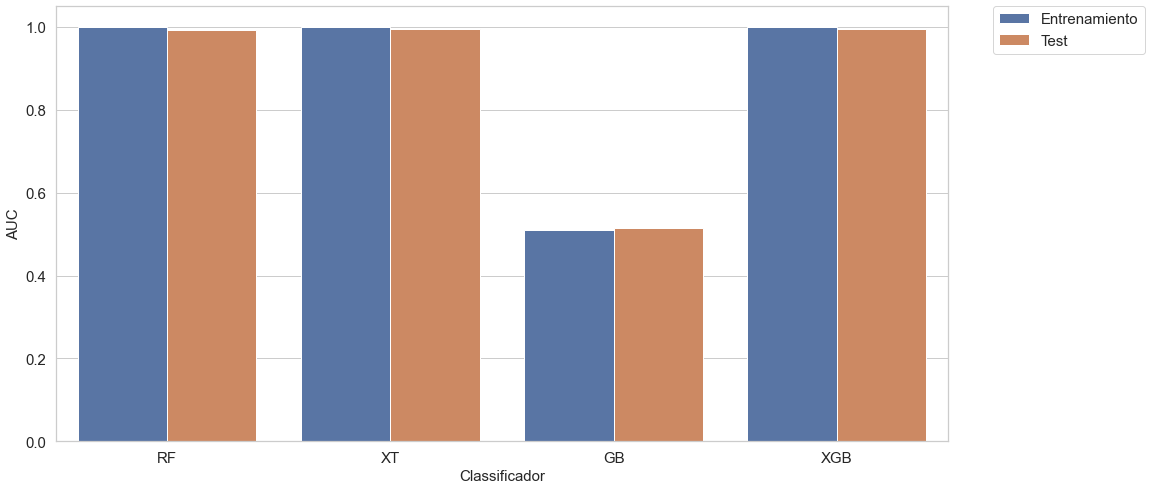

In [258]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)
plt.show()

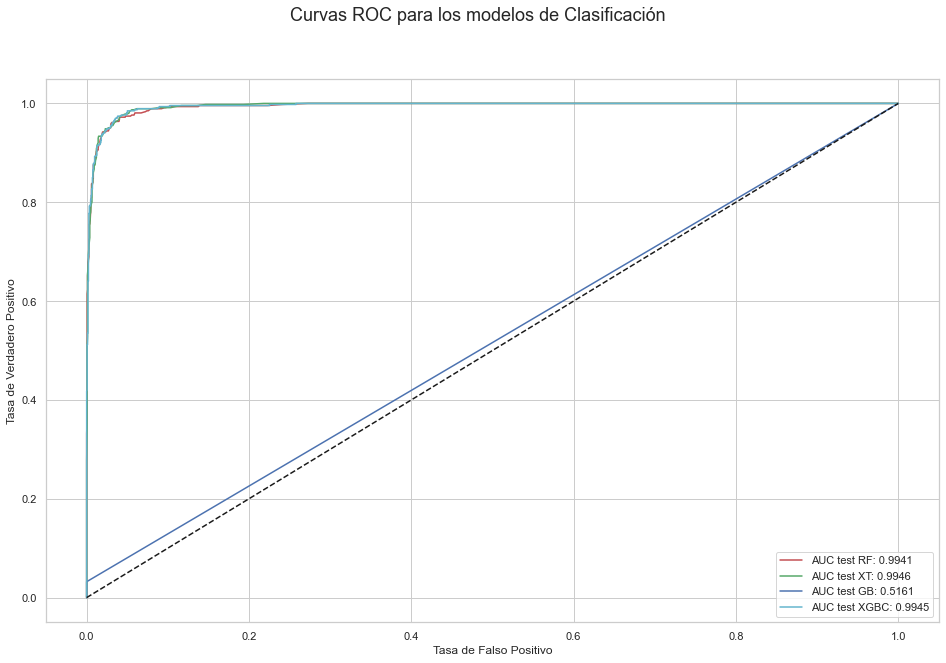

In [261]:
# Calcula la curva ROC con los datos predichos test

# Modelo RF
fpr_test_rf, tpr_test_rf, thresholds_test_rf = roc_curve(y_test, y_test_preds_rf)
auc_test_rf = roc_auc_score(y_test, y_test_preds_rf)

# Modelo Extra trees
fpr_test_xt, tpr_test_xt, thresholds_test_xt = roc_curve(y_test, y_test_preds_xt)
auc_test_xt = roc_auc_score(y_test, y_test_preds_xt)

# Modelo GradientBooster
fpr_test_gb, tpr_test_gb, thresholds_test_gb = roc_curve(y_test, y_test_preds_gbc)
auc_test_gb = roc_auc_score(y_test, y_test_preds_gbc)

# Modelo XGBC
fpr_test_xgbc, tpr_test_xgbc, thresholds_test_xgbc = roc_curve(y_test, y_test_preds_xgbc)
auc_test_xgbc = roc_auc_score(y_test, y_test_preds_xgbc)


# Plot
plt.figure(figsize=(16,10))
plt.plot(fpr_test_rf, tpr_test_rf, 'r-', label ='AUC test RF: %.4f'%auc_test_rf)
plt.plot(fpr_test_xt, tpr_test_xt, 'g-', label ='AUC test XT: %.4f'%auc_test_xt)
plt.plot(fpr_test_gb, tpr_test_gb, 'b-', label ='AUC test GB: %.4f'%auc_test_gb)
plt.plot(fpr_test_xgbc, tpr_test_xgbc, 'c-', label ='AUC test XGBC: %.4f'%auc_test_xgbc)

plt.plot([0,1],[0,1],'k--')
plt.xlabel('Tasa de Falso Positivo')
plt.ylabel('Tasa de Verdadero Positivo')
plt.suptitle('Curvas ROC para los modelos de Clasificación', fontsize=18)
plt.legend()
plt.show()

### Deploy de los Modelos
Vamos a aplicar el modelo a datos nuevos. Determinaremos la probabilidad de sufrir una crisis epiléptica, con cada modelo.

In [262]:
nuevo_paciente = pd.read_csv('C:/Users/Cesar Hooper/Desktop/python/mini_projeto1/dados/novo_paciente.csv')

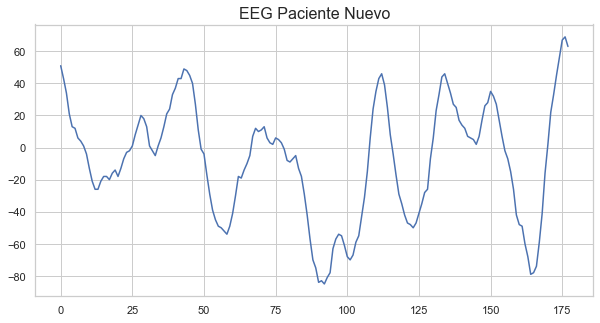

In [274]:
plt.figure(figsize=(10,5))
plt.plot(list(nuevo_paciente.iloc[0]))
plt.title('EEG Paciente Nuevo', fontsize=16)
plt.show()

In [275]:
# normalizacón
nuevo_normalizado = scaler.transform(nuevo_paciente)
nuevo_normalizado

array([[ 0.38355727,  0.3301782 ,  0.27553552,  0.1901356 ,  0.13145759,
         0.11662125,  0.07569924,  0.06384182,  0.0436729 ,  0.00870754,
        -0.05142561, -0.10057883, -0.12196895, -0.11407354, -0.08153653,
        -0.06434411, -0.06807988, -0.08295483, -0.06197991, -0.05207367,
        -0.07784708, -0.04434749, -0.00290861,  0.02364608,  0.02718861,
         0.04205221,  0.08419217,  0.12122693,  0.16114311,  0.15202733,
         0.12271365,  0.04356081,  0.01933163, -0.00342686,  0.03281666,
         0.06741172,  0.11584793,  0.16883507,  0.19061499,  0.24465823,
         0.2713319 ,  0.31035151,  0.30594227,  0.33240967,  0.31785735,
         0.29879522,  0.27247897,  0.20383622,  0.11306401,  0.04453041,
         0.02560215, -0.05491795, -0.13006336, -0.19231631, -0.23195711,
        -0.26205764, -0.2685351 , -0.27317867, -0.2696695 , -0.22326446,
        -0.17103123, -0.11060721, -0.04769984, -0.06370309, -0.04325399,
        -0.02769054, -0.00061519,  0.07549832,  0.1

In [280]:
# Aplicación de los modelos
# RF
pred_nuevo_rf = rfc.predict_proba(nuevo_normalizado)

# XT
pred_nuevo_xt = xtc.predict_proba(nuevo_normalizado)

# GBC
pred_nuevo_gb = gbc.predict_proba(nuevo_normalizado)

# XGBC
pred_nuevo_xgbc = xgbc.predict_proba(nuevo_normalizado)

In [295]:
print( 'Previsión Random Forest: %.3f'%pred_nuevo_rf[:,0] + '\n',
     'Previsión Extra Trees: %.3f'%pred_nuevo_xt[:,0] + '\n',
     'Previsión Gradient Booster: %.3f'%pred_nuevo_gb[:,0]+'\n', 
     'Previsión Extra Gradient Booster: %.3f'%pred_nuevo_xgbc[:,0])

Previsión Random Forest: 1.000
 Previsión Extra Trees: 1.000
 Previsión Gradient Booster: 0.998
 Previsión Extra Gradient Booster: 1.000


Según todos los modelos, el paciente tiene probabilidad cercana a 1.0 de no sufrir crisis epilépticas.

## FIN